# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 2.1

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

plt.style.use('fivethirtyeight')

# Going Classy

## The Class

## The Constructor

### Arguments

### Placeholders

### Variables

### Functions

### Step Methods

## Training Methods

### Mini-Batch

### Training Loop

## Saving and Loading Methods

### Saving

### Loading

### Making Predictions

## Visualization Methods

### Losses

### Model Graph

## The Full Code

In [37]:
class StepByStep():
    def __init__(self, model, loss_fn, optimizer):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Create the train_step function for model, loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Create the val_step function for model and loss function
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to interface with TensorBoard
        suffix = datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keep track of the numbers of epochs by updating the corresponding attribute
            self.total_epochs += 1

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Flush the writer
            self.writer.flush()

    def save_checkpoint(self, filename):
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'losses': self.losses,
                      'val_losses': self.val_losses}
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['losses']
        self.val_losses = checkpoint['val_losses']

        self.model.train()  # always use TRAIN for resuming training

    def predict(self, x):
        # Set it to evaluation mode for predictions
        self.model.eval()

        x_tensor = torch.as_tensor(x).float().to(self.device)
        y_hat_tensor = self.model(x_tensor)

        # Set it back to train mode
        self.model.train()

        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.legend()
        fig.tight_layout()
        return fig

    def add_graph(self):
        if self.train_loader and self.writer:
            # Fetche a single mini-batch so we can use add_graph
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

    def _make_train_step_fn(self):
        # Build function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            self.model.train()

            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()

        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Build function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            self.model.eval()

            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)

            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation` defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn
        
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

## Classy Pipeline

### Data Generation

In [42]:
%run -i data_generation/simple_linear_regression.py

### Data Preparation V2

In [43]:
%run -i data_preparation/v2.py

### Model Configuration V4

In [14]:
%%writefile model_configuration/v4.py

lr = .1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

Writing model_configuration/v4.py


In [44]:
%run -i model_configuration/v4.py

In [45]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.7645]]), '0.bias': tensor([0.8300])})


## Model Training

### Cell 2.1.1

In [46]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

In [47]:
print(sbs.model == model)
print(sbs.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


### Cell 2.1.2

In [48]:
sbs.train(n_epochs=200)

In [49]:
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

OrderedDict({'0.weight': tensor([[2.0171]], device='cuda:0'), '0.bias': tensor([0.9983], device='cuda:0')})
200


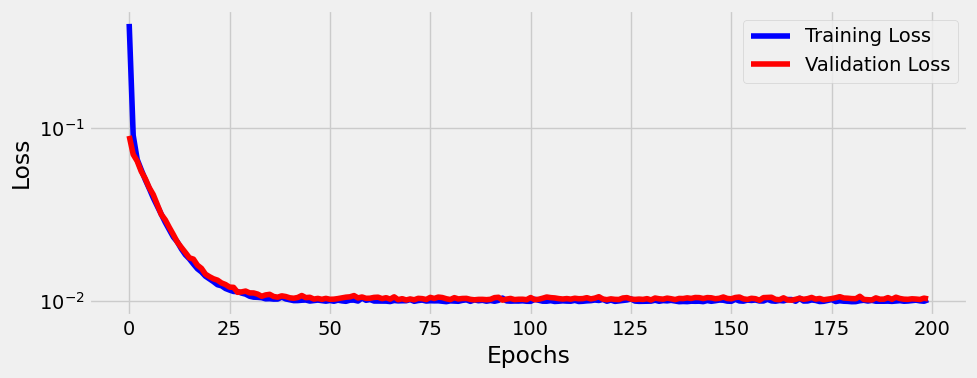

In [50]:
fig = sbs.plot_losses()

### Making Predictions

In [24]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [51]:
predictions = sbs.predict(new_data)
predictions

array([[2.006826 ],
       [1.6033996],
       [2.410252 ]], dtype=float32)

### Checkpointing

### Cell 2.1.3

In [52]:
sbs.save_checkpoint('model_checkpoint.pth')

### Resuming Training

In [53]:
%run -i model_configuration/v4.py

In [54]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.7645]]), '0.bias': tensor([0.8300])})


### Cell 2.1.4

In [55]:
new_sbs = StepByStep(model, loss_fn, optimizer)

### Cell 2.1.5

In [56]:
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0171]], device='cuda:0'), '0.bias': tensor([0.9983], device='cuda:0')})


/tmp/ipykernel_41706/2950881866.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


### Cell 2.1.6

In [57]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)

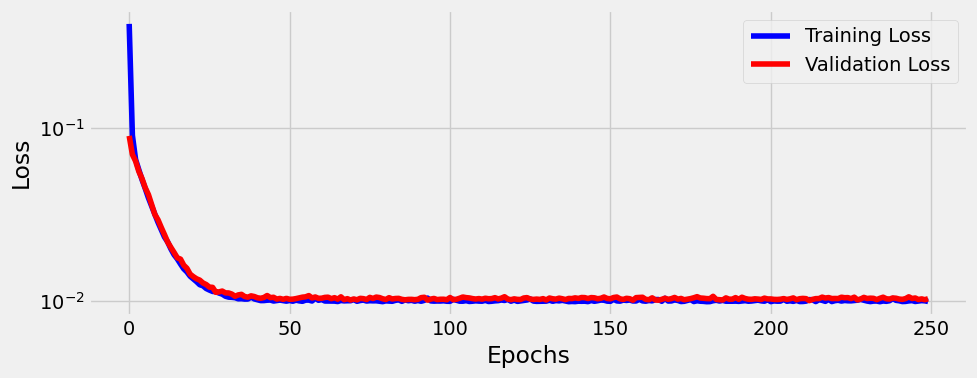

In [58]:
fig = new_sbs.plot_losses()

In [59]:
print(sbs.model.state_dict())

OrderedDict({'0.weight': tensor([[2.0171]], device='cuda:0'), '0.bias': tensor([0.9983], device='cuda:0')})


# Putting It All Together

In [ ]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Build tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float().reshape(-1, 1)
y_tensor = torch.from_numpy(y).float().reshape(-1, 1)

# Build dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Perform split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Build a loader for each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [ ]:
# %load model_configuration/v4.py

lr = .1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
n_epochs = 200

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')
sbs.train(n_epochs=n_epochs)

In [ ]:
print(model.state_dict())